In [1]:
import numpy as np
import matplotlib.pyplot as plt
import causallearn
from causallearn.utils.cit import *
from causallearn.graph.GraphClass import CausalGraph
import pandas as pd
from itertools import combinations, permutations
from numpy import ndarray
from typing import Dict, List, Tuple
from causallearn.utils.cit import fisherz
import random
import time

import scipy as sp

# Initialize Dataset (Sample num_traj trajectories of length T)

In [11]:
traj_dataset = pd.read_csv('raw_dat_finance.csv')
traj_dataset.drop('date',axis=1, inplace=True)


In [16]:
traj_dataset = np.array(traj_dataset)
traj_dataset.shape

(3832, 4)

In [36]:
beta = 0.6
num_states = 2
num_inputs = 20
num_obs = 1
A = np.random.normal(0,1, (num_states,num_states))
B = (np.ones(num_inputs * num_states)*beta).reshape(num_states, num_inputs) 
T = 2
C = np.random.normal(0, 1, (num_obs, num_states))
num_traj = 20000

for traj_id in range(num_traj):
    x_vec = np.zeros((num_states, T))
    y_vec = np.zeros((num_obs, T))
    x_vec[:, 0] = np.random.randn(num_states)
    y_vec[:, 0] = C@ x_vec[:,0]
    u_vec = np.random.randn(num_inputs, T)
    #w_vec = np.random.randn(2,T) * np.sqrt(1 - alpha**2 - beta**2)
    
    for t in range(T-1):
    #     print(t)
        x_vec[:, t+1] = A @ x_vec[:, t] + B @ u_vec[:,t] #+ w_vec[:, t]
        y_vec[:,t+1] = C@ x_vec[:,t+1]
    
    x_u_vec = np.block([[x_vec], [u_vec]])
    y_u_vec = np.block([[y_vec], [u_vec]])
    if traj_id == 0:
        traj_dataset = np.zeros((num_traj, x_u_vec.shape[0], x_u_vec.shape[1]))
        traj_dataset[0, :, :] = x_u_vec
        obs_dataset = np.zeros((num_traj, y_u_vec.shape[0], y_u_vec.shape[1]))
        obs_dataset[0, :, :] = y_u_vec
    else:
        traj_dataset[traj_id, :, :] = x_u_vec
        obs_dataset[traj_id, :, :] = y_u_vec


In [18]:
modified_pc_KSK(traj_dataset, 2, 0.02)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [38]:
y_vec

array([[ -2.23069655, -10.3474563 ]])

In [39]:
# plt.plot(traj_dataset)
traj_dataset.shape

(20000, 22, 2)

In [40]:
assert traj_dataset.shape == (num_traj, num_states + num_inputs, T)
assert obs_dataset.shape == (num_traj, num_obs + num_inputs, T)

In [41]:
num_traj, num_quantities, _ = traj_dataset.shape
num_traj, num_quantities, _ = obs_dataset.shape

# num_quantities

In [ ]:
def modified_pc_finance(data, m, rho_m):
    num_traj, num_quantities = data.shape
    input_indices = []
    
    for j in range(num_quantities):
        node_indices_to_test = np.random.choice(num_quantities, m)
        for count, i in enumerate(node_indices_to_test):
            corr = sp.stats.pearsonr(traj_dataset[:, i, 0], traj_dataset[:, j, 1])[0]
            if abs(corr) >= 0.5*rho_m:
                break
            if count == m-1:
                input_indices.append(j)
                
    return input_indices

def compute_rhos(A, B):
    # Returns num_states array x (num_states + num_inputs)
    # Accurate only under the given assumptions.
    
    variances = np.linalg.norm(np.block([A, B]), axis = 1)
    rho_array = np.block([A, B]) / variances[:,None]
    
    return rho_array

# Modified PC Algorithm for Learning Number of Inputs

In [17]:
def modified_pc_KSK(data, m, rho_m):
    num_traj, num_quantities, _ = data.shape
    input_indices = []
    
    for j in range(num_quantities):
        node_indices_to_test = np.random.choice(num_quantities, m)
        for count, i in enumerate(node_indices_to_test):
            corr = sp.stats.pearsonr(traj_dataset[:, i, 0], traj_dataset[:, j, 1])[0]
            if abs(corr) >= 0.5*rho_m:
                break
            if count == m-1:
                input_indices.append(j)
                
    return input_indices

def compute_rhos(A, B):
    # Returns num_states array x (num_states + num_inputs)
    # Accurate only under the given assumptions.
    
    variances = np.linalg.norm(np.block([A, B]), axis = 1)
    rho_array = np.block([A, B]) / variances[:,None]
    
    return rho_array

In [43]:
rho_vec = np.sort(abs(compute_rhos(A, B).flatten()), axis=None)
rho_vec[0:350]

array([0.10168587, 0.1313013 , 0.1318061 , 0.13817497, 0.13817497,
       0.13817497, 0.13817497, 0.13817497, 0.13817497, 0.13817497,
       0.13817497, 0.13817497, 0.13817497, 0.13817497, 0.13817497,
       0.13817497, 0.13817497, 0.13817497, 0.13817497, 0.13817497,
       0.13817497, 0.13817497, 0.13817497, 0.2205017 , 0.2205017 ,
       0.2205017 , 0.2205017 , 0.2205017 , 0.2205017 , 0.2205017 ,
       0.2205017 , 0.2205017 , 0.2205017 , 0.2205017 , 0.2205017 ,
       0.2205017 , 0.2205017 , 0.2205017 , 0.2205017 , 0.2205017 ,
       0.2205017 , 0.2205017 , 0.2205017 , 0.77510046])

In [44]:
list_1 = [3, 4, 5]
list_2 = [4, 5, 6]

list_1_not_2 = [k for k in list_1 if k not in list_2]
list_2_not_1 = [k for k in list_2 if k not in list_1]

In [11]:
begin_time = time.time()

m_list = [2*x + 2 for x in list(range(10))]
rho_min_list = [x * 0.02 + 0.02 for x in list(range(5))]
input_indices_true = list(range(50, 70))
num_trials = 10

false_positive_avg_array = np.zeros((len(m_list), len(rho_min_list)))
missed_detection_avg_array = np.zeros((len(m_list), len(rho_min_list)))

for count_m, m in enumerate(m_list):
    print("\n")
    print("count_m:", count_m)
    for count_rho, rho_min in enumerate(rho_min_list):
        print("count_rho", count_rho)
        false_positive_quantity_list = []
        missed_detection_quantity_list = []
        for trial_id in range(num_trials):
            input_indices_est = modified_pc_KSK(traj_dataset, m, rho_min)
            false_positive_quantity_list.append(len([k for k in input_indices_est if k not in input_indices_true]))
            missed_detection_quantity_list.append(len([k for k in input_indices_true if k not in input_indices_est]))
        false_positive_avg_array[count_m, count_rho] = sum(false_positive_quantity_list)/len(false_positive_quantity_list)
        missed_detection_avg_array[count_m, count_rho] = sum(missed_detection_quantity_list)/len(missed_detection_quantity_list)

end_time = time.time()
print("Time:", end_time - begin_time)
        
# print(modified_pc_CYC(traj_dataset, 10, 0.05))





count_m: 0
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 1
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 2
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 3
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 4
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 5
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 6
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 7
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 8
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 9
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4
Time: 1.5524508953094482


In [53]:
begin_time = time.time()

m_list = [2*x + 2 for x in list(range(10))]
rho_min_list = [x * 0.02 + 0.02 for x in list(range(5))]
input_indices_true = list(range(2, 21))
num_trials = 10

false_positive_avg_array = np.zeros((len(m_list), len(rho_min_list)))
missed_detection_avg_array = np.zeros((len(m_list), len(rho_min_list)))

for count_m, m in enumerate(m_list):
    print("\n")
    print("count_m:", count_m)
    for count_rho, rho_min in enumerate(rho_min_list):
        print("count_rho", count_rho)
        false_positive_quantity_list = []
        missed_detection_quantity_list = []
        for trial_id in range(num_trials):
            input_indices_est = modified_pc_KSK(obs_dataset, m, rho_min)
            false_positive_quantity_list.append(len([k for k in input_indices_est if k not in input_indices_true]))
            missed_detection_quantity_list.append(len([k for k in input_indices_true if k not in input_indices_est]))
        false_positive_avg_array[count_m, count_rho] = sum(false_positive_quantity_list)/len(false_positive_quantity_list)
        missed_detection_avg_array[count_m, count_rho] = sum(missed_detection_quantity_list)/len(missed_detection_quantity_list)

end_time = time.time()
print("Time:", end_time - begin_time)
        
# print(modified_pc_CYC(traj_dataset, 10, 0.05))





count_m: 0
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 1
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 2
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 3
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 4
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 5
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 6
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 7
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 8
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4


count_m: 9
count_rho 0
count_rho 1
count_rho 2
count_rho 3
count_rho 4
Time: 40.93988108634949


In [52]:
input_indices_true = list(range(2, 21))
input_indices_true


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [47]:
rho_min_list

[0.02, 0.04, 0.06, 0.08, 0.1]

In [54]:
print(false_positive_avg_array)
print(missed_detection_avg_array)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[ 5.6  0.1  0.   0.   0. ]
 [ 8.1  0.   0.   0.   0. ]
 [13.   0.3  0.   0.   0. ]
 [14.3  0.5  0.   0.   0. ]
 [14.8  0.3  0.   0.   0. ]
 [15.2  0.4  0.   0.   0. ]
 [15.8  0.7  0.   0.   0. ]
 [16.8  0.6  0.   0.   0. ]
 [17.5  0.2  0.   0.   0. ]
 [17.5  0.7  0.   0.   0. ]]


Text(0.5, 1.0, 'False Positives')

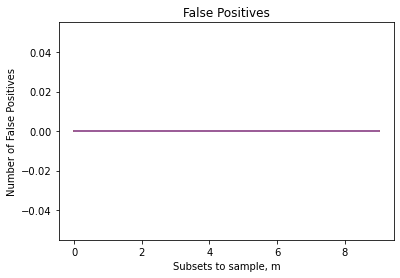

In [55]:
plt.plot(false_positive_avg_array)
plt.xlabel('Subsets to sample, m')
plt.ylabel('Number of False Positives')
plt.title('False Positives')

In [56]:
missed_detection= missed_detection_avg_array.mean(axis = 0)

Text(0.5, 1.0, 'Missed Detections')

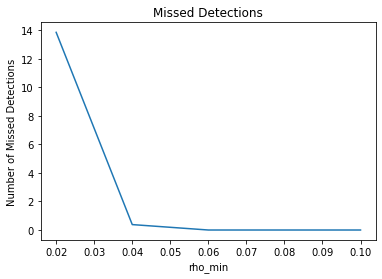

In [57]:

plt.plot(rho_min_list,missed_detection)
plt.xlabel('rho_min')
plt.ylabel('Number of Missed Detections')
plt.title('Missed Detections')

In [245]:
# Save results:

path_directory = "/Users/chih-yuanchiu/Desktop/Code/Causality_Time_Series/data/"

path_file = path_directory + "false_positive_avg_array.csv"
false_positive_avg_array_pd = pd.DataFrame(false_positive_avg_array)
false_positive_avg_array_pd.to_csv(path_file, index=False)

path_file = path_directory + "missed_detection_avg_array.csv"
missed_detection_avg_array_pd = pd.DataFrame(missed_detection_avg_array)
missed_detection_avg_array_pd.to_csv(path_file, index=False)



# Kshitij's algorithms:

In [ ]:
def compute_sample_corr(data,i,j, num_samples):
    avg_t_plus = (1/num_samples)*data[:,i].sum()
    avg_t = (1/num_samples)*data[:,j].sum()
    diff_t_plus = data[:, i] - avg_t_plus
    diff_t = data[:,j] - avg_t_plus
    diff_t_plus_sq = (diff_t_plus**2).sum()
    diff_t_sq = (diff_t**2).sum()
    corr = (np.dot(diff_t_plus, diff_t))/np.sqrt((diff_t_plus_sq*diff_t_sq))
    return corr

def modified_pc(data, m, num_samples, num_observations, rho_m):
    input_set = []
    for i in range(data.shape[1]):
        subset = np.array(random.sample(list(range(data.shape[1])), m))
        for j in subset:
            rho_m_hat = compute_sample_corr(data, i,j, num_samples)
            if abs(rho_m_hat) >= 0.5*rho_m:
                break 
            if j == subset[-1]:
                input_set.append(i)
    return input_set


